# Greedy MSU selection

Choose MSU locations based on which improves overall utility most.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classes.geography_processing import Geoprocessing
from classes.model import Model
from classes.scenario import Scenario

# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Proportion of treated patients that are LVO
prop_lvo = 0.40

# Maximum number of hospitals to select
max_hospitals = 100

## Base case

MSU provided from comprehensive stroke centres (thrombectomy centres)

In [3]:
# Set up scenario
scenario = Scenario({
    'name': 1,
    'limit_to_england' : True
})

# Process and save geographic data (only needed when hospital data changes)
geo = Geoprocessing(limit_to_england=True); geo.run()

# Set up model
model = Model(
    scenario=scenario,
    geodata=pd.read_csv('processed_data/processed_data.csv'))

# Run model
model.run()

# Get utilities
lsoa_drip_ship_utility = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility'] * (1 - prop_lvo)))

# Get the weighted average of lsoa_drip_ship_utility 
average_utility_drip_ship = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility) / np.sum(model.full_results['Admissions'])

lsoa_drip_ship_utility_shift = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

lsoa_msu_utility_shift = (
    (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

# Get the maximum of MSU and drip and ship
best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

# Get the weighted average of lsoa_drip_ship_utility shift 
average_utility_drip_ship_shift = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the average utility weighted by model.full_results['Admissions']
average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the advantage of MSU over drip and ship
advantage = average_utility_shift - average_utility_drip_ship_shift

In [4]:
untreated_utility = (average_utility_drip_ship - average_utility_drip_ship_shift)
print(f'Average untreated utility: {untreated_utility:0.3f}')
print(f'Average utility improvement for drip and ship: {average_utility_drip_ship_shift:0.3f}')
print(f'Average utility advantage for MSU over drip and ship: {advantage:0.3f}')


Average untreated utility: 0.493
Average utility improvement for drip and ship: 0.086
Average utility advantage for MSU over drip and ship: 0.024


In [5]:
# Set up scenario
scenario = Scenario({
    'name': 1,
})

# Set up geoprocessing module and load initial data (and  set Use_MSU column to zero
geo = Geoprocessing(limit_to_england = True)
geo.load_data()
geo.hospitals['Use_MSU'] = 0

# Travel processing for constant locations
geo.find_nearest_ivt_unit()
geo.find_nearest_mt_unit()
geo.find_nearest_transfer_mt_unit()

# Set up list of selected and unselected MSUs
selected_MSUs = []
used_hospitals_mask = geo.hospitals['Use_IVT'] == 1
unelected_MSUs = list(geo.hospitals[used_hospitals_mask].index)

## Benefit from each hospital as a MSU base


In [6]:
geo.hospitals['Use_MSU'] = 0
hospitals = geo.hospitals.copy(deep=True)
                                   
# Loop through all MSUs
possible_msu_locations = list(geo.hospitals[used_hospitals_mask].index)
advantages = []

for msu in possible_msu_locations:
    data_copy = hospitals.copy(deep=True)
    data_copy.loc[msu, 'Use_MSU'] = 1
    geo.hospitals = data_copy.copy()
    geo.find_nearest_msu_unit()
    geo.collate_data()
    geo.save_processed_data()

    model = Model(
        scenario=scenario,
        geodata=pd.read_csv('processed_data/processed_data.csv')
    )

    model.run()

    # Get utilitites
    lsoa_msu_utility_shift = (
        (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

    lsoa_drip_ship_utility_shift = (
        (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

    # Get the maximum of MSU and drip and ship
    best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

    # Get the weighted average of lsoa_drip_ship_utility
    average_utility_drip_ship_shift = np.sum(
        model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the average utility weighted by model.full_results['Admissions']
    average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the advantage of MSU over drip and ship
    advantage = average_utility_shift - average_utility_drip_ship_shift

    advantages.append(advantage)


results = geo.hospitals.copy(deep=True)
results = results[used_hospitals_mask]
results['MSU advantage'] = advantages

results.to_csv('output/msu_advantages_individual.csv')

## Greedy selection of MSUs

In [7]:
hospitals = geo.hospitals.copy(deep=True)
best_advantage = 0
advantages = []

# Loop through greedy selection process
while (len(unelected_MSUs) > 0) & (len(selected_MSUs) < max_hospitals):

    # Loop through all MSUs
    for msu in unelected_MSUs:
        data_copy = hospitals.copy(deep=True)
        data_copy.loc[msu, 'Use_MSU'] = 1
        geo.hospitals = data_copy.copy()
        geo.find_nearest_msu_unit()
        geo.collate_data()
        geo.save_processed_data()

        model = Model(
            scenario=scenario,
            geodata=pd.read_csv('processed_data/processed_data.csv')
        )

        model.run()
        
            # Get utilitites
        lsoa_msu_utility_shift = (
            (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

        lsoa_drip_ship_utility_shift = (
            (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

        # Get the maximum of MSU and drip and ship
        best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

        # Get the weighted average of lsoa_drip_ship_utility
        average_utility_drip_ship_shift = np.sum(
            model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the average utility weighted by model.full_results['Admissions']
        average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the advantage of MSU over drip and ship
        advantage = average_utility_shift - average_utility_drip_ship_shift
        
        if advantage > best_advantage:
            best_advantage = advantage
            best_MSU = msu

    # Add the best MSU to the selected list
    selected_MSUs.append(best_MSU)
    unelected_MSUs.remove(best_MSU)
    hospitals.loc[best_MSU, 'Use_MSU'] = 1
    advantages.append(best_advantage)

    # print the best MSU and utility
    print(f'{best_MSU}, {best_advantage:0.3f}')

E11BB, 0.007
M68HD, 0.011
B714HJ, 0.014
DN25LT, 0.016
DH15TW, 0.017
BS105NB, 0.018
KT160PZ, 0.019
NR47UY, 0.020
LE15WW, 0.021
EX25DW, 0.021
DA28DA, 0.022
LS13EX, 0.023
LU40DZ, 0.023
BN112DH, 0.023
CO45JL, 0.024
NG72UH, 0.024
L97AL, 0.025
PE39GZ, 0.025
PR29HT, 0.025
TR13LQ, 0.025
HU32JZ, 0.026
ST46QG, 0.026
BH77DW, 0.026
GL13NN, 0.026
CA27HY, 0.027
CT13NG, 0.027
NE14LP, 0.027
TS43BW, 0.027
HA13UJ, 0.027
OX39DU, 0.027
PL68DH, 0.028
BA214AT, 0.028
S102JF, 0.028
BN212UD, 0.028
CB20QQ, 0.028
SS165NL, 0.028
TF16TF, 0.028
LN25QY, 0.029
NN15BD, 0.029
PO63LY, 0.029
SW170QT, 0.029
CV22DX, 0.029
EX314JB, 0.029
RG15AN, 0.029
YO318HE, 0.029
PO305TG, 0.029
SN36BB, 0.029
SK27JE, 0.030
HR12ER, 0.030
CH495PE, 0.030
DE223NE, 0.030
LA144LF, 0.030
BD96RJ, 0.030
PE304ET, 0.030
BS234TQ, 0.030
NG174JL, 0.030
RM70AG, 0.030
NR316LA, 0.030
TQ27AA, 0.030
SG14AB, 0.030
WR51DD, 0.030
BL97TD, 0.031
BA13NG, 0.031
ME169QQ, 0.031
IP45PD, 0.031
RH15RH, 0.031
GU167UJ, 0.031
NW12BU, 0.031
TA15DA, 0.031
HP112TT, 0.031
BB2

In [8]:
greedy_results = geo.hospitals.loc[selected_MSUs]
greedy_results['MSU advantage'] = advantages
greedy_results.to_csv('output/msu_advantages_greedy.csv', index=False)
greedy_results

,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,MSU advantage
Postcode,,,,,,,,,,,,,,,,,,,,,
E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,...,13.4,534829,181798,-0.058133,51.519018,1,1,Royal London,NaN,0.006566
M68HD,M68HD,1,1,1,England,Manchester,Lancashire & S.Cumbria SCN,Salford Royal NHS Foundation Trust,Salford Royal Hospital,1848,...,6.5,378637,399030,-2.323424,53.487545,1,1,Salford,NaN,0.010841
B714HJ,B714HJ,1,0,1,England,West Midlands SCN,Sandwell and West Birmingham Hospitals NHS Trust,"Sandwell District Hospital, West Bromwich",Sandwell District Hospital,741,...,6.7,400919,292165,-1.987884,52.527357,0,0,West Bromwich,NaN,0.013992
DN25LT,DN25LT,1,0,1,England,Yorkshire and The Humber SCN,Doncaster and Bassetlaw Hospitals NHS Foundati...,Doncaster Royal Infirmary,Doncaster Royal Infirmary,694,...,9.5,459143,404157,-1.109226,53.530751,0,0,Doncaster,NaN,0.015819
DH15TW,DH15TW,1,0,1,England,North of England SCN,County Durham and Darlington NHS Foundation Trust,University Hospital of North Durham,University Hospital of North Durham,961,...,9.8,426217,543809,-1.593834,54.788497,0,0,North Durham,NaN,0.017359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD180HB,WD180HB,1,0,1,England,East of England SCN,West Hertfordshire Hospitals NHS Trust,Watford General Hospital,Watford General Hospital,607,...,13.5,510505,195664,-0.404187,51.648921,0,0,Watford,NaN,0.031762
TS198PE,TS198PE,1,0,1,England,North of England SCN,North Tees and Hartlepool NHS Foundation Trust,University Hospitals of North Tees and Hartlepool,University Hospitals of North Tees and Hartlepool,632,...,19.0,442265,521046,-1.347581,54.582857,0,0,Stockton-on-Tees,NaN,0.031785
SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,...,9.9,524226,176487,-0.212736,51.473717,1,1,Charing Cross,NaN,0.031807


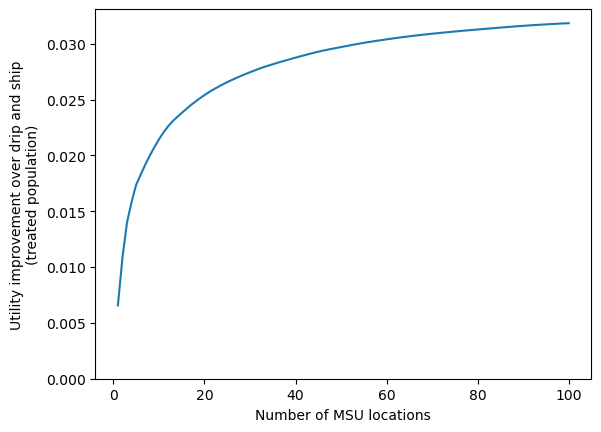

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage']
ax.plot(x, y, '-')
ax.set_xlabel('Number of MSU locations')
ax.set_ylabel('Utility improvement over drip and ship\n(treated population)')
ax.set_ylim(0)

plt.show()
